In [68]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
import time
import io
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import threading
import torchvision.models as models
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel,GPT2Model
from nltk.corpus import wordnet
from caption_transforms import SimCLRData_Caption_Transform
from image_transforms import SimCLRData_image_Transform
from dataset import FlickrDataset
from models import ResNetSimCLR,OpenAI_SIMCLR
from utils import get_gpu_stats,layerwise_trainable_parameters,count_trainable_parameters
from metrics import ContrastiveLoss
from metrics import LARS,Optimizer_simclr
from logger import Logger
"""import nltk
nltk.download('omw-1.4')"""
get_gpu_stats()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from datetime import datetime
#/home1/08629/pradhakr/cv


cuda
No of GPUs i have is 2
0
My Graphic Card is Tesla P100-PCIE-16GB
Is Cuda Available True


In [69]:
random.seed(42)

# Set the seed for PyTorch's random number generator
torch.manual_seed(42)

# Create train and test datasets using FlickrDataset
train_dataset = FlickrDataset('data/', "data/train", 'train',
                              image_transform=SimCLRData_image_Transform(),
                              caption_transform=SimCLRData_Caption_Transform())

test_dataset = FlickrDataset('data/', "data/test", 'test',
                             image_transform=SimCLRData_image_Transform(),
                             caption_transform=SimCLRData_Caption_Transform())


In [70]:
batch_size = 64

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

orginal caption: a large photo of a large body of water
caption1: a large photo of a large body of water
caption2: a large of a large body of water


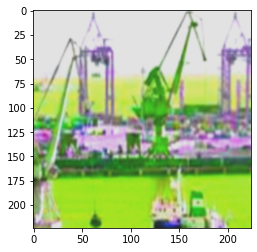

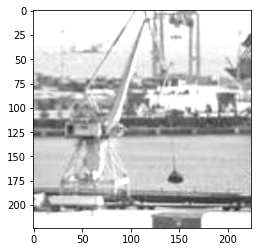

In [71]:
img1, img2, caption,caption1, caption2 = test_dataset[5]
plt.imshow(img1.permute(1, 2, 0))

# Show augmented image
plt.figure()
plt.imshow(img2.permute(1, 2, 0))
print('orginal caption:',caption)
print('caption1:',caption1)
print('caption2:',caption2)
plt.show()

In [72]:
for i in train_loader:
    s=i
    break

In [49]:
gpt_model = OpenAI_SIMCLR(model='openai-gpt', projection_dim=128,layers_to_train=['h.11']).to(device)
a,b=gpt_model([ "Hello, how are you doing today?"],device)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [52]:
b.shape

torch.Size([1, 128])

In [36]:
input_text = "Hello, how are you doing today?"
input_ids = torch.tensor(tokenizer.encode(input_text)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
pooled_output = torch.mean(outputs, dim=1)

In [55]:
model_resnet=ResNetSimCLR(model='resnet50',projection_dim=128,encoder_last_layer=1024,layers_to_train=['layer4']).to(device)
print('total parameters_resnet',count_trainable_parameters(model_resnet))
gpt_model = OpenAI_SIMCLR(model='openai-gpt', projection_dim=128,encoder_last_layer=1024,layers_to_train=['h.11']).to(device)
print('total parameters_gpt',count_trainable_parameters(gpt_model))

total parameters_resnet 18243712


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


total parameters_gpt 9056128


In [56]:
a_image,b_image=model_resnet(s[0],device)
a_image1,b_image1=model_resnet(s[1],device)
a_caption,b_caption=gpt_model(s[3],device)
a_caption1,b_caption1=gpt_model(s[4],device)

In [57]:
print(b_image.shape,b_caption.shape)

torch.Size([64, 128]) torch.Size([64, 128])


In [59]:
NXTENT_loss=ContrastiveLoss(device,temperature=0.07)
print(NXTENT_loss(b_image,b_caption, batch_size)+NXTENT_loss(b_caption1,b_image1,batch_size).item())

tensor(28.4564, device='cuda:0', grad_fn=<AddBackward0>)


In [67]:
NXTENT_loss(b_caption,b_caption1, batch_size)

tensor(3.2518, device='cuda:0', grad_fn=<DivBackward0>)

In [20]:
Learning_rate=0.03
Momentum=0.09
temperature=0.07
weight_decay=0
optimizer_type='sgd'
NXTENT_loss=ContrastiveLoss(device,temperature=temperature)
optimizer_image = Optimizer_simclr(optimizer_name=optimizer_type, model_parameters=model_resnet.parameters(), lr=Learning_rate,
                             momentum=Momentum, weight_decay=weight_decay)
optimizer_text = Optimizer_simclr(optimizer_name=optimizer_type, model_parameters=gpt_model.parameters(), lr=Learning_rate,
                             momentum=Momentum, weight_decay=weight_decay)
OPTIMIZER_image=optimizer_image.optimizer
scheduler_image=optimizer_image.scheduler
OPTIMIZER_text=optimizer_text.optimizer
scheduler_text=optimizer_text.scheduler

In [24]:
def train(dataloader, image_model, text_model, optimizer_image, optimizer_text, criterion,device,
          scheduler_image=None, scheduler_text=None, trade_off_ii=1, trade_off_cc=1):

    loss_epoch = 0

    for idx, batch in enumerate(dataloader):
        image_model.train()
        text_model.train()

        batch_size = batch[0].shape[0]
        image1, image2, caption1, caption2 = batch[0], batch[1], batch[3], batch[4]

        _, embed_image1 = image_model(image1, device)
        _, embed_image2 = image_model(image2, device)
        _, embed_caption1 = text_model(caption1, device)
        _, embed_caption2 = text_model(caption2, device)

        intra_loss = (trade_off_ii * criterion(embed_image1, embed_image2, batch_size) +
                      trade_off_cc * criterion(embed_caption1, embed_caption2, batch_size))

        intra_loss.backward()

        optimizer_image.step()
        optimizer_text.step()

        optimizer_image.zero_grad()
        optimizer_text.zero_grad()

        loss_epoch += intra_loss.item()

        del batch, image1, image2, caption1, caption2, embed_image1, embed_image2, embed_caption1, embed_caption2, intra_loss
        torch.cuda.empty_cache()
    if scheduler_image:
            scheduler_image.step()
    if scheduler_text:
            scheduler_text.step()
    print(optimizer_image.get_lr())
    epoch_loss = loss_epoch / len(dataloader)
    return epoch_loss

def test(dataloader,image_model,text_model,criterion,trade_off_ii=1,trade_off_cc=1):
    
        
        
    trade_off_ii,trade_off_cc=1,1
    loss_epoch=0
    with torch.no_grad():
        for idx,batch in enumerate(dataloader):
            image_model.eval()
            text_model.eval()
            batch_size=batch[0].shape[0]
            image1,image2,caption1,caption2 =batch[0],batch[1],batch[3],batch[4]

            _,embed_image1=image_model(image1,device)

            _,embed_image2=image_model(image2,device)

            _,embed_caption1=text_model(caption1,device)

            _,embed_caption2=text_model(caption2,device)

            intra_loss=(trade_off_ii*criterion(embed_image1,embed_image2,batch_size) +
                            trade_off_cc*criterion(embed_caption1,embed_caption2,batch_size))


            loss_epoch += intra_loss.item()

            del batch, image1, image2, caption1, caption2, embed_image1, embed_image2, embed_caption1, embed_caption2, intra_loss

            torch.cuda.empty_cache()

    epoch_loss=loss_epoch/len(dataloader)
    return epoch_loss

In [8]:
total_epochs=100
trial_number=999
log_dir = os.path.join(os.getenv('WORK'), 'cv_project')
image_caption_filename=os.path.join(log_dir, 'image_caption')
train_log=os.path.join(image_caption_filename, f'train_{trial_number}.log')
image_model_log=os.path.join(image_caption_filename, f'image_model_{trial_number}.pth')
text_model_log=os.path.join(image_caption_filename, f'text_model_{trial_number}.pth')
graph_save_dir='/home1/08629/pradhakr/cv/graphs/image_caption'

In [9]:
logger_save=Logger(train_log,image_model_log,text_model_log, optimizer_type, 
            Learning_rate, weight_decay, batch_size,Momentum,temperature,total_epochs)
logger_save.start_training()

for epoch in tqdm(range(total_epochs)):
    
    start=time.time()
    
    
    train_loss=train(dataloader=train_loader,  image_model=model_resnet,  text_model=gpt_model,
    optimizer_image=OPTIMIZER_image,   optimizer_text =  OPTIMIZER_text,criterion=NXTENT_loss,
                     scheduler_image=scheduler_image, scheduler_text=scheduler_text,   trade_off_ii=1,   trade_off_cc=1)
    test_loss=test(dataloader=test_loader,  image_model=model_resnet,  text_model=gpt_model,criterion =NXTENT_loss
         ,trade_off_ili=1,trade_off_cc=1)
    
    end=time.time()
    logger_save.log(epoch+1,model_resnet,gpt_model,  train_loss, test_loss, end-start)

logger_save.end_training()
logger_save.plot_losses(trial_number,graph_save_dir)

TypeError: __init__() missing 8 required positional arguments: 'trade_off_cc', 'trade_off_ii', 'resnet_model_name', 'gpt_model_name', 'resnet_layers', 'gpt_layers', 'total_resnet_parameters_train', and 'total_gpt_parameters_train'